In [1]:
import networkx as nx
import pylab as plt
import pandas as pd
import numpy as np
import math
from timeit import default_timer as timer
from matplotlib.pyplot import figure


In [2]:
PR_df = pd.read_csv('./PR_df.csv')
PR_df.sort_values(by='0',inplace = True, ascending=False)
PR_df.reset_index(drop = True, inplace = True)
PR_df.rename(columns={'Unnamed: 0':'Author', '0':'PR_values'}, inplace = True)
PR_df

,Author,PR_values
0,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,0.042414
1,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,0.015953
2,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,0.014931
3,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,0.014887
4,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,0.014411
...,...,...
873,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,0.000483
874,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,0.000483
875,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,0.000483
876,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,0.000483


In [3]:
DB_AA_originale = pd.read_csv('./DB_articles_authors_built.csv')


#genesis_tx_node_id = DB_AA_originale[DB_AA_originale['To_Author_Pub_key']=='Not_available']['ToNodeId'].values[0]
#RIMUOVO LE CITAZIONI INIZIALI FATTE VERSO LA GENESIS TX DAGLI ARTICOLI DI FRONTIERA
#DB_AA_originale = DB_AA_originale[DB_AA_originale['ToNodeId']!= genesis_tx_node_id]
DB_AA_originale

,FromNodeId,From_Author_Pub_Key,ToNodeId,To_Author_Pub_key
0,bea8b41266f68383aab0ab6f11e1423db72df15ff8357a...,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,7abd48c9ff5cd7ed0f42d4879fde173481d087ea25372f...,Not_available
1,48f59e57815078456b89fe34932606fcf1e5fa7874cf00...,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,7abd48c9ff5cd7ed0f42d4879fde173481d087ea25372f...,Not_available
2,e2e9da947c52e0f6107d5aa5d6e03e0e9fcafe7bccde08...,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,7abd48c9ff5cd7ed0f42d4879fde173481d087ea25372f...,Not_available
3,f2b1c07718734fb4f48789faef537bc69604b53befe340...,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,48f59e57815078456b89fe34932606fcf1e5fa7874cf00...,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...
4,c356dd48fe8a94bc92ef446443ee88f49eb28dee5e95bd...,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,7abd48c9ff5cd7ed0f42d4879fde173481d087ea25372f...,Not_available
...,...,...,...,...
2190,11be570f418641c06fe7a7bb832b237a51d3a6f1615f3a...,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,1a730dd1844edc082bd852f6a8617db09885158f30e105...,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...
2191,11be570f418641c06fe7a7bb832b237a51d3a6f1615f3a...,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,3cbf33b87b930b9f7861e16e41b2596d98ddb08c128afb...,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...
2192,11be570f418641c06fe7a7bb832b237a51d3a6f1615f3a...,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,860b9434133c78fede874d0380cf50697b49af8c7c0b8d...,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...
2193,11be570f418641c06fe7a7bb832b237a51d3a6f1615f3a...,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,c4a161d608769cd6fe604685c9204f81351eb9f07032a7...,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...


In [4]:
DB_AA_originale.FromNodeId.nunique()

1066

In [5]:
DB_AA_originale.ToNodeId.nunique()

663

In [6]:
genesis_tx_node_id = DB_AA_originale[DB_AA_originale['To_Author_Pub_key']=='Not_available']['ToNodeId'].values[0]
#RIMUOVO LE CITAZIONI INIZIALI FATTE VERSO LA GENESIS TX DAGLI ARTICOLI DI FRONTIERA
DB_AA_originale_senza_genesis = DB_AA_originale[DB_AA_originale['ToNodeId']!= genesis_tx_node_id]

res = DB_AA_originale_senza_genesis.groupby('To_Author_Pub_key')['From_Author_Pub_Key'].count()
cit_entranti_max = res.max()
cit_entranti_max


58

In [7]:
def readMsgDB():
    print('Checking for local message_id stored...\n')
    try: 
        file = open("lista_msgDB.txt", "r")
        msg_DB = file.readlines()

        for i in range(len(msg_DB)):
            msg_DB[i] = msg_DB[i].replace("\n", "")

        print(f'Found #{len(msg_DB)} messages from the file lista_msgDB.txt \n')

        file.close() 
    except:
        
        msg_DB = []

    
    return msg_DB

msg_DB = readMsgDB()

Checking for local message_id stored...

Found #1066 messages from the file lista_msgDB.txt 



In [8]:
DB_AA_originale[DB_AA_originale['FromNodeId'].isin(msg_DB)]

,FromNodeId,From_Author_Pub_Key,ToNodeId,To_Author_Pub_key
0,bea8b41266f68383aab0ab6f11e1423db72df15ff8357a...,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,7abd48c9ff5cd7ed0f42d4879fde173481d087ea25372f...,Not_available
1,48f59e57815078456b89fe34932606fcf1e5fa7874cf00...,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,7abd48c9ff5cd7ed0f42d4879fde173481d087ea25372f...,Not_available
2,e2e9da947c52e0f6107d5aa5d6e03e0e9fcafe7bccde08...,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,7abd48c9ff5cd7ed0f42d4879fde173481d087ea25372f...,Not_available
3,f2b1c07718734fb4f48789faef537bc69604b53befe340...,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,48f59e57815078456b89fe34932606fcf1e5fa7874cf00...,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...
4,c356dd48fe8a94bc92ef446443ee88f49eb28dee5e95bd...,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,7abd48c9ff5cd7ed0f42d4879fde173481d087ea25372f...,Not_available
...,...,...,...,...
2190,11be570f418641c06fe7a7bb832b237a51d3a6f1615f3a...,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,1a730dd1844edc082bd852f6a8617db09885158f30e105...,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...
2191,11be570f418641c06fe7a7bb832b237a51d3a6f1615f3a...,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,3cbf33b87b930b9f7861e16e41b2596d98ddb08c128afb...,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...
2192,11be570f418641c06fe7a7bb832b237a51d3a6f1615f3a...,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,860b9434133c78fede874d0380cf50697b49af8c7c0b8d...,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...
2193,11be570f418641c06fe7a7bb832b237a51d3a6f1615f3a...,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,c4a161d608769cd6fe604685c9204f81351eb9f07032a7...,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...


In [9]:
Communities = pd.read_csv('./Best_Clusters_DF.csv')
Communities.sort_values(by='cluster_size',inplace = True)

Communities.reset_index(drop = True, inplace = True)

def replaceSlash(row):
    return row.replace('\\n','\n')

repS = np.vectorize(replaceSlash)

Communities.cluster_authors = repS(Communities.cluster_authors)

Communities

,cluster_authors,cluster_size
0,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,2
1,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,2
2,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,2
3,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,2
4,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,2
...,...,...
66,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,35
67,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,45
68,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,50
69,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,82


In [10]:
Communities.cluster_size.sum()

871

In [11]:
Communities.index.values

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70], dtype=int64)

In [22]:
#t = DB_AA_originale[DB_AA_originale['From_Author_Pub_Key'].isin(Communities.iloc[2]['cluster_authors'].split("*"))]
#t[t['To_Author_Pub_key'].isin(Communities.iloc[0]['cluster_authors'].split("*"))]

,FromNodeId,From_Author_Pub_Key,ToNodeId,To_Author_Pub_key


In [19]:
#TEST FATTO IGNORANDO I WEIGHT TRA LE COMMUNITIES, CONSIDERO SOLO I #HOP

num_nodi = len(Communities)


#GRAPH CREATION


#STAMPA GRAFO
D=nx.DiGraph()

for i in Communities.index.values:
    D.add_node(str(i),nodeId = str(i))
    
for i in Communities.index.values: 
    
    inner_authors = Communities.iloc[i]['cluster_authors'].split("*")
    
    for j in Communities.index.values:
        
        if(i!=j):
        
            outer_authors = Communities.iloc[j]['cluster_authors'].split("*")

            temp_df = DB_AA_originale[DB_AA_originale['From_Author_Pub_Key'].isin(inner_authors)]

            temp_df = temp_df[temp_df['To_Author_Pub_key'].isin(outer_authors)]

            #print(temp_df)

            if(len(temp_df) > 0):           

                D.add_weighted_edges_from([(str(i),str(j),len(temp_df))])


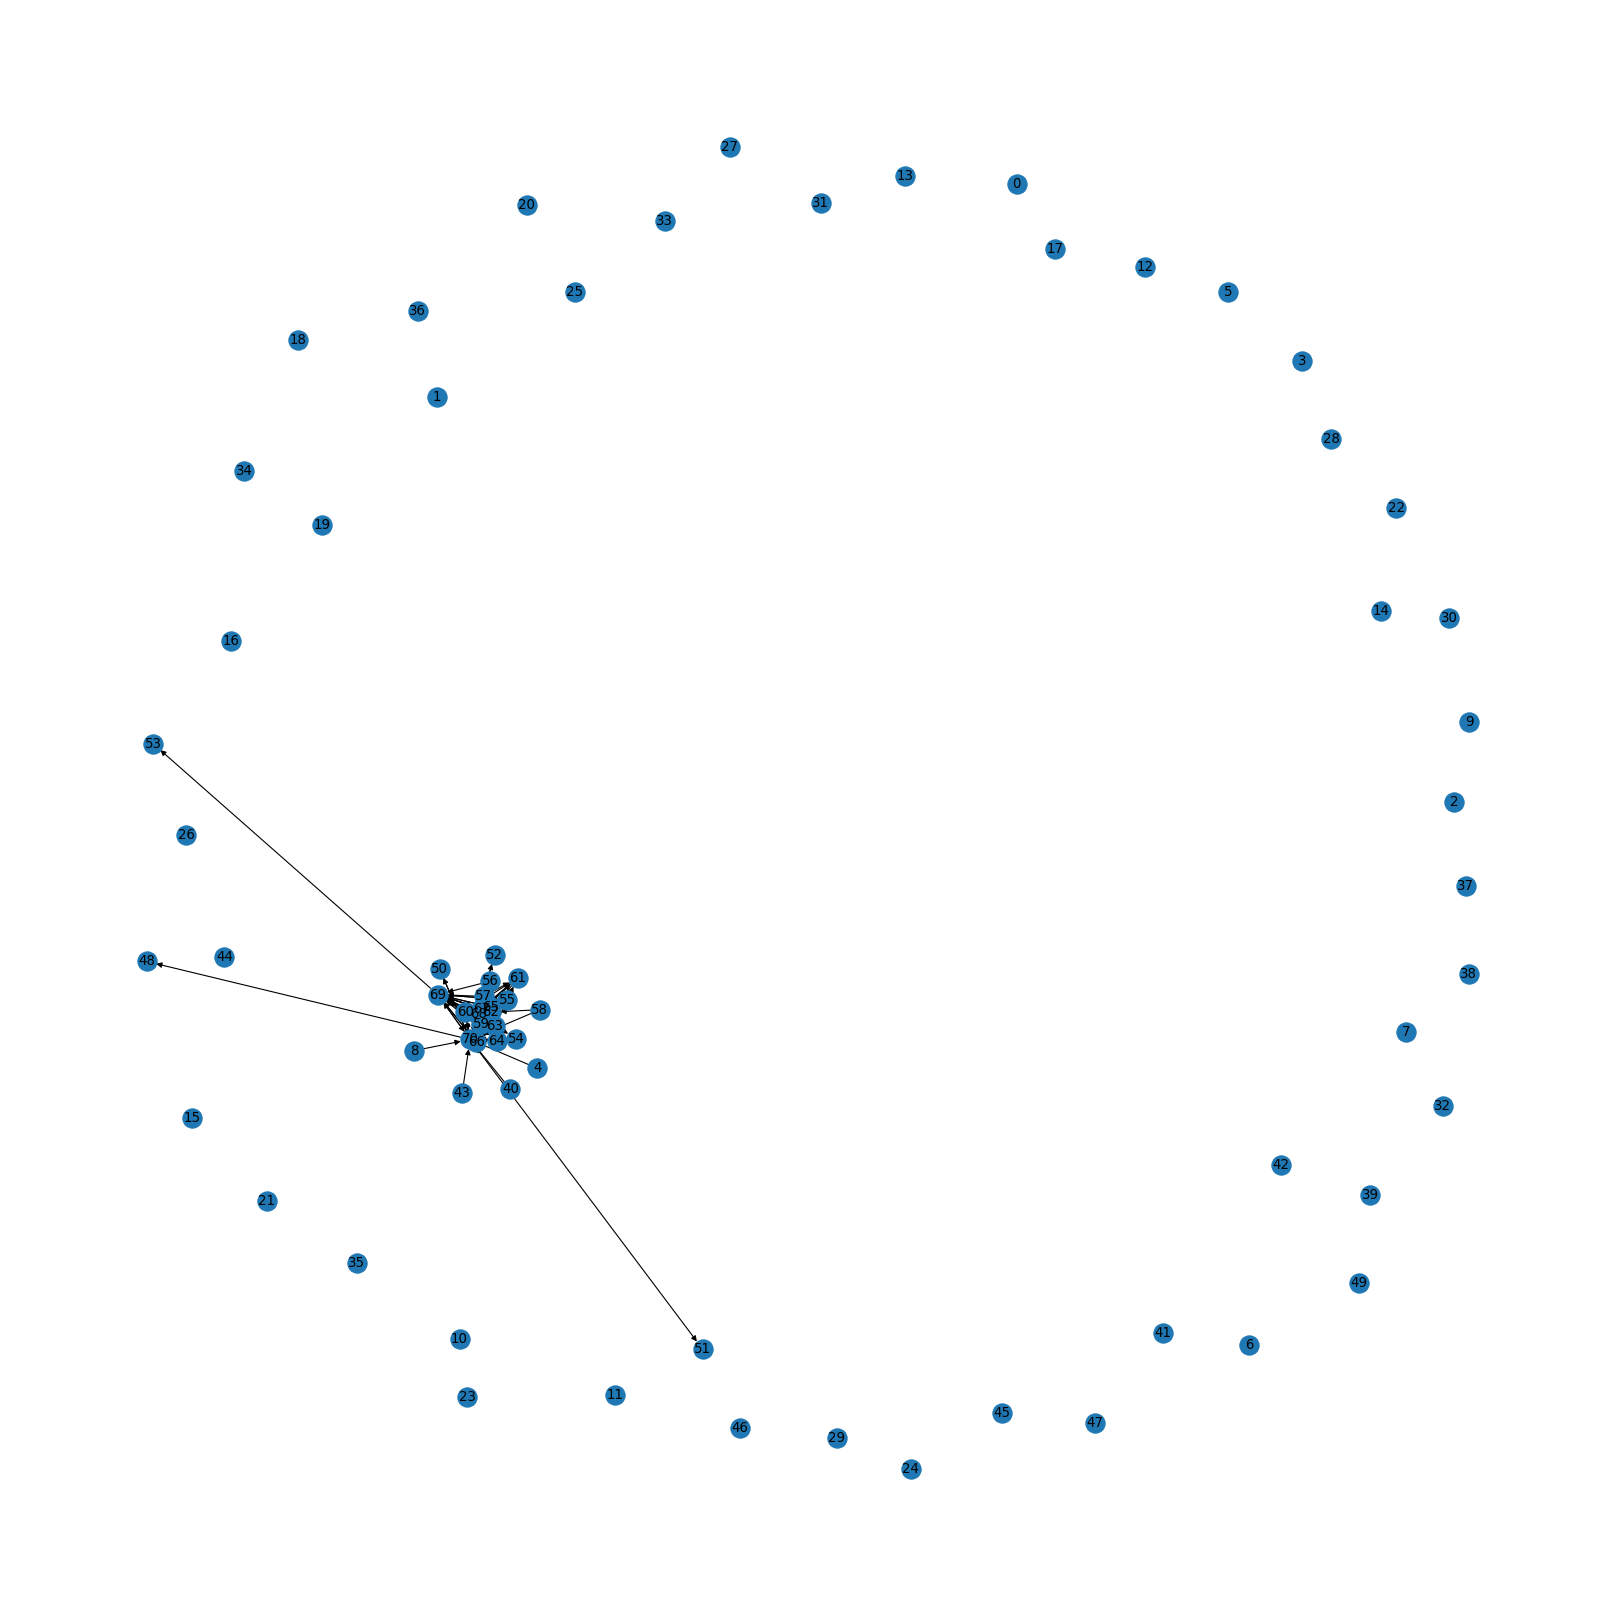

In [18]:
figure(figsize=(20, 20), dpi=80)

nx.draw(D, with_labels=True)
plt.show()

D ha tanti nodi quante communities ed esiste un arco tra due communities A-B <=> almeno un autore di community A cita almeno un autore della community B

In [23]:
Communities_splitted = pd.DataFrame(columns=['community','authors'])
Communities_splitted.community = range(0,len(Communities))
Communities_splitted.set_index('community',inplace = True)

lun = 0

for i in range(len(Communities)):
    autori = Communities.loc[i]['cluster_authors'].split("*")
    Communities_splitted.loc[i]['authors'] = autori
    lun += len(autori)
    
print(lun)
    
Communities_splitted.head()

871


,authors
community,
0,[-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9...
1,[-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9...
2,[-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9...
3,[-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9...
4,[-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9...


In [24]:
Communities_splitted.iloc[0]['authors']

['-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w0BAQEFAAOCAQ8AMIIBCgKCAQEA0dnd/2q1miceFJ4M/Hjo\nUGblGQjv0Slq9wPjlJpjD0qMzHFyct46l+gqfRYxVtoFEsQRqTLfj8CMcjJvn439\nxMlXByjnCXpI/y+SYHQNK+4STV/MnO5pr01B1ZDerHrBFcQu/IdKMhXwVBCb5gwP\nlzCeiP9Shw4I40rbU1zs593SBEPvQry681j210mbwge0TfkjDc4qCFJT5zACiQrB\nJzG86oankBgh/2X+Grlm8T4LlmVjvOajFAZsTwZta7HK3JX/a2z+OIdaaRwYwbkW\nQ17irPSo79E+Mczw7MzxRIIsegWGH/HzKRmgBLbVEN9fciAXcMoUzZuSRmjCKMwM\nHQIDAQAB\n-----END PUBLIC KEY-----\n',
 '-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w0BAQEFAAOCAQ8AMIIBCgKCAQEAtdv2ONOW6Csv8p1BK2Cg\nrQDP8koxz7h1ka2T/zw7opKQyyQljw63XCXwSVVKS5EtSKrBuQPWkM38uN98pvsW\nPevxUHBW+aueCjkLJBg46v7Ttu4NV0tOVMQT+ehyCQSzgma5guR3HO5QzrolwBK1\n9bSL4+8Tu5v993vQzuAKFuL7cP0WaD1iigmwCeP8JU6tBtX1HJ2Pi7IilGNC0q4T\nT1rAbSgmwqTGwWIVI52rMEbaddvhMyhdnQmg0XVrkRXX1dLe4skBCgCFz0U+YV63\nBlycRVrl7iFPJgOW/I4HRL+716Yg2Cldjo9Gifod/mGeyV8qlPBVkRStJsHFKWuc\nXQIDAQAB\n-----END PUBLIC KEY-----\n']

In [25]:
stima_veridicita_articoli = pd.DataFrame(columns=['article_id','estimate'])
stima_veridicita_articoli['article_id'] = msg_DB
stima_veridicita_articoli.set_index('article_id',inplace = True)
stima_veridicita_articoli

,estimate
article_id,
bea8b41266f68383aab0ab6f11e1423db72df15ff8357a1a769b5f4005b39533,NaN
48f59e57815078456b89fe34932606fcf1e5fa7874cf00498999ed99247a73b1,NaN
e2e9da947c52e0f6107d5aa5d6e03e0e9fcafe7bccde08b259ca41eb31c8a358,NaN
f2b1c07718734fb4f48789faef537bc69604b53befe3402c7fe4cfd0f71ededb,NaN
c356dd48fe8a94bc92ef446443ee88f49eb28dee5e95bd334c2dfd039e019a4d,NaN
...,...
642acd3957e86003df21148bec1f62cd6ecce16c7bab00fc9fcc5e766a0a2886,NaN
a90d93063f81d04b7b2b2a7ad70aa0a4ae1900c05d5328ecc5f1da486cbce44e,NaN
f1cb6682fae35ace95e977735bbe2976c10c1a77ed3b877b56aefc8a65ee9519,NaN


a[PR(auth_i)/PR_Max] + b[#cit_entranti_i/#cit_entranti_Max] + c[AVG(PR_auth_citano_i)/PR_Max] + d[Communities value]

In [63]:
#max_pr
PR_Max = PR_df.query('PR_values == PR_values.max()')['PR_values'][0]
print(PR_Max)

#max_cit_entranti
res = DB_AA_originale_senza_genesis.groupby('To_Author_Pub_key')['From_Author_Pub_Key'].count()
cit_entranti_max = res.max()
print(cit_entranti_max)

#max_len_#_hop
path = dict(nx.all_pairs_dijkstra_path(D))
max_len = 0
for node in D.nodes:
    for paths in path[node]:
        local_len = len(path[node][paths])
        if(local_len > max_len):
            max_len = local_len

max_len = max_len-1 #perche il primo nodo non conta, è il nodo da cui si parte 
print(max_len)

a = 0.2
b = 0.2
c = 0.2
d = 0.4

0.0424140089724826
58
5


In [64]:
len(path.keys()) 

71

In [65]:
def computeMinOfHopAvgDist(communities_citanti):

    min_avg_dist = max_len
    for i in communities_citanti:

        local_avg_dist = 0

        for j in communities_citanti:
            if(i!=j):
                if(str(j) in path[str(i)]):
                    local_avg_dist += len(path[str(i)][str(j)])-1
                else:
                    local_avg_dist += max_len

        if(local_avg_dist < min_avg_dist):
            min_avg_dist = local_avg_dist

    return min_avg_dist

In [66]:
stima = []

for m in msg_DB:


#print(article_id)

    autore = DB_AA_originale[DB_AA_originale['FromNodeId']==m]['From_Author_Pub_Key'].values[0]
    PR_autore = PR_df[PR_df['Author']==autore]['PR_values'].values[0]
    num_cit_entranti = len(DB_AA_originale[DB_AA_originale['To_Author_Pub_key']==autore])
    autori_citanti = DB_AA_originale[DB_AA_originale['To_Author_Pub_key']==autore]['From_Author_Pub_Key'].values
    
    if(len(autori_citanti)>0):
        AVG_PR_autori_citanti = PR_df[PR_df['Author'].isin(autori_citanti)]['PR_values'].values.mean()
    else:
        AVG_PR_autori_citanti = 0
    #print(autori_citanti)

    #calcolo la distanza tra le communities che mi citano

    communities_citanti = []

    for i in autori_citanti:
        for j in range(len(Communities_splitted)):
            if(i in Communities_splitted.loc[j]['authors'] ):
                communities_citanti.append(j)

    communities_citanti = np.unique(communities_citanti)

    Min_of_hop_avg_dist = computeMinOfHopAvgDist(communities_citanti)

    stima_veridicita_articoli.loc[m]['estimate'] = a*(PR_autore/PR_Max) + b*(num_cit_entranti/cit_entranti_max) + c*(AVG_PR_autori_citanti/PR_Max) + d*(Min_of_hop_avg_dist/max_len)  

In [67]:
stima_veridicita_articoli

,estimate
article_id,
bea8b41266f68383aab0ab6f11e1423db72df15ff8357a1a769b5f4005b39533,0.009946
48f59e57815078456b89fe34932606fcf1e5fa7874cf00498999ed99247a73b1,0.016374
e2e9da947c52e0f6107d5aa5d6e03e0e9fcafe7bccde08b259ca41eb31c8a358,0.042797
f2b1c07718734fb4f48789faef537bc69604b53befe3402c7fe4cfd0f71ededb,0.016374
c356dd48fe8a94bc92ef446443ee88f49eb28dee5e95bd334c2dfd039e019a4d,0.009946
...,...
642acd3957e86003df21148bec1f62cd6ecce16c7bab00fc9fcc5e766a0a2886,0.40228
a90d93063f81d04b7b2b2a7ad70aa0a4ae1900c05d5328ecc5f1da486cbce44e,0.40228
f1cb6682fae35ace95e977735bbe2976c10c1a77ed3b877b56aefc8a65ee9519,0.40228


<AxesSubplot:xlabel='article_id'>

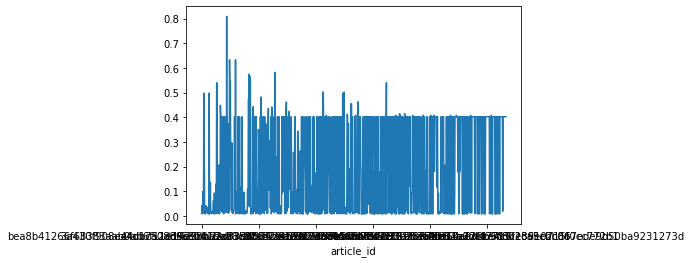

In [68]:
stima_veridicita_articoli.estimate.plot()

In [69]:
stima_veridicita_articoli[stima_veridicita_articoli['estimate']>0.8]

,estimate
article_id,
93baf4b22089d33fdae3233ccf412e48cc88b5ffff5b2e59387cd1cc01b90281,0.809301


In [49]:
DB_AA_originale[DB_AA_originale['FromNodeId']=='93baf4b22089d33fdae3233ccf412e48cc88b5ffff5b2e59387cd1cc01b90281']

,FromNodeId,From_Author_Pub_Key,ToNodeId,To_Author_Pub_key
92,93baf4b22089d33fdae3233ccf412e48cc88b5ffff5b2e...,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,7abd48c9ff5cd7ed0f42d4879fde173481d087ea25372f...,Not_available


In [50]:
DB_AA_originale[DB_AA_originale['ToNodeId']=='93baf4b22089d33fdae3233ccf412e48cc88b5ffff5b2e59387cd1cc01b90281']

,FromNodeId,From_Author_Pub_Key,ToNodeId,To_Author_Pub_key
122,56a5211750b64381c2ee8efe83b6278bba821be802f2a7...,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,93baf4b22089d33fdae3233ccf412e48cc88b5ffff5b2e...,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...
138,f8afcbac1abec292980bda4d0e03329fda0c427fcc3e97...,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,93baf4b22089d33fdae3233ccf412e48cc88b5ffff5b2e...,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...
147,5a211a03cca045c13df5df2924b2856f920f07b2c59be1...,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,93baf4b22089d33fdae3233ccf412e48cc88b5ffff5b2e...,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...
153,7db12a2a41c51fa5ebb4819cab6cf3238f936077883b40...,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,93baf4b22089d33fdae3233ccf412e48cc88b5ffff5b2e...,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...
160,b6bb71ab76a9c1dbf993ebb28b8ac8bee4fa64a7c348a4...,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,93baf4b22089d33fdae3233ccf412e48cc88b5ffff5b2e...,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...
194,c3ec48fd6e0d2494c02282ef4ef44d842364499a9c8472...,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,93baf4b22089d33fdae3233ccf412e48cc88b5ffff5b2e...,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...
216,ebd0f9f8daab93cf63cb8e9032da7de661bf5eeee76192...,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,93baf4b22089d33fdae3233ccf412e48cc88b5ffff5b2e...,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...
224,a3b30b8b9c1588f621dcfc24ca34f5e5c5b14785ef8bf2...,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,93baf4b22089d33fdae3233ccf412e48cc88b5ffff5b2e...,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...
227,a272958399a842ced2841a80c00118a3b13e28362bd313...,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,93baf4b22089d33fdae3233ccf412e48cc88b5ffff5b2e...,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...
229,400c97c2e5662f431a408e5a474baf2dcf1be63a860b7f...,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,93baf4b22089d33fdae3233ccf412e48cc88b5ffff5b2e...,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...


In [52]:
len(DB_AA_originale[DB_AA_originale['ToNodeId']=='93baf4b22089d33fdae3233ccf412e48cc88b5ffff5b2e59387cd1cc01b90281'])

58

In [70]:
stima_veridicita_articoli.estimate.mean()

0.18308788535162362

58